# Fisher KPP on bounded domain in 1D

$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x)=D\frac{\partial^2}{\partial x^2} u(t,x) + u(t,x)(r(x) - \gamma(x)u(t,x)), t\geq 0, x\in [0,l]\\
\begin{cases}
u(t,0)=u(t,l)=0,t\geq 0, \text{Dirichlet condition}\\
\frac{\partial u(t,x)}{\partial n}\Big|_{x\in\{0,l\}}=\frac{\partial^2}{\partial x^2} u(t,x)\cdot n=0, t\geq0,\text{Neumann condition},
\end{cases}\\
u(0,x)=u_0(x),x\in [0,l]
\end{cases}
$$

In all that follows, $r(x)$, $\gamma(x)$ et $D$ are considered constant.

__Note :__ Neumann boundary condition [wiki](https://en.wikipedia.org/wiki/Neumann_boundary_condition) fixes the value of the derivative on the boundary points. $0$ means that there is no flux through the boundary.

Les expériences de référence associées sont donc (III.29), (IV.3) ou (III.43) du livre _Modèles de réaction-diffusion pour l'écologie spatiale_ par Lionel Roques.

Different kinds of solutions are expected:

- For bounded $\Omega$, eg: $x\in[0, l]$:

  - Population persists if $\lambda_1 < 0$

  - Population goes extinct if $\lambda_1 > 0$
with
$$
\begin{cases}
\lambda_1=\frac{\pi^2}{l^2}D - r,\text{ for Dirichlet boundary condition}\\
\lambda_1=-r, \text{ for Neumann boundary condition},
\end{cases}
$$

$\lambda_1$ is the main eigenvalue of the linear elliptical operator associated with the modele.

- For unbounded $\Omega$, eg: $x\in\mathbb{R}$:
  - We can have wavefront-like solutions: see the other Fisher KPP notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [3]:
import jinns

/home/hugo/anaconda3/envs/pinn2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial

import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)


Create the neural network architecture for the PINN with `equinox`. Note that we will use the same architecture for the 3 populations.

In [5]:
eqx_list = [
    [eqx.nn.Linear, 2, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.tanh],
    [eqx.nn.Linear, 50, 1],
    [jnp.exp]
]
key, subkey = random.split(key)
init_param_fn, u = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 1)


In [6]:
init_nn_params = init_param_fn()

Create a DataGenerator object

In [7]:
n = 1000
nb = 2
nt = 1000
omega_batch_size = 32
temporal_batch_size = 20
omega_border_batch_size = 2
dim = 1
xmin = -1
xmax = 1
tmin = 0
tmax = 1
method = "uniform"

Tmax = 5
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin,),
    (xmax,),
    tmin,
    tmax,
    method
)

Initialize the PINN parameters and visualize the PINN output before training

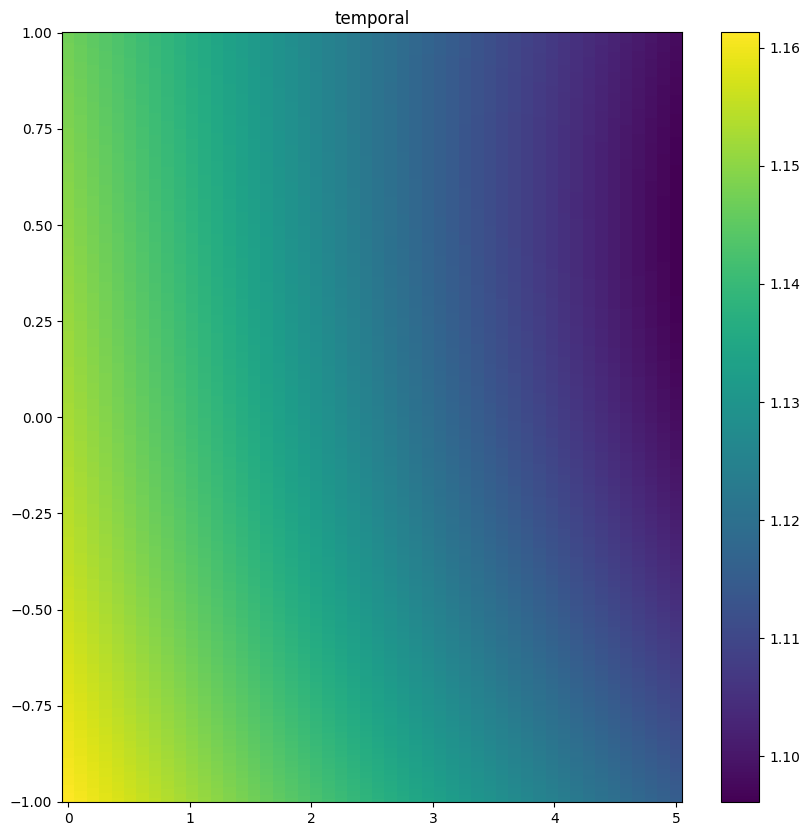

In [8]:
u_init = partial(u, u_params=init_nn_params)
nx = 1000
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 50
val_times = jnp.linspace(tmin, tmax, ntime)

jinns.data.plot1d_image(u_init, xdata=val_xdata, times=val_times, Tmax=Tmax, cmap="viridis", colorbar=True, figsize=(10,10), title="temporal")

## Set up the initial condition

Text(0.5, 1.0, 'Init condition $u_0$')

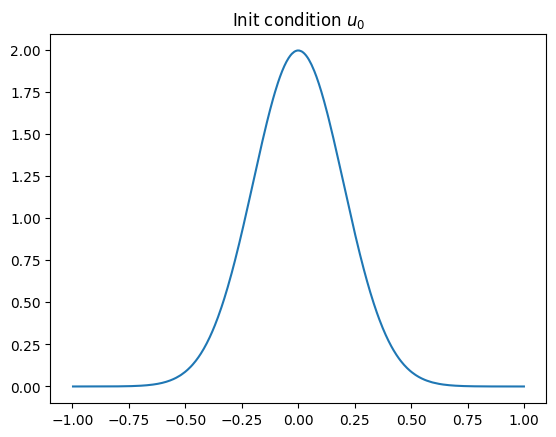

In [9]:
from jax.scipy.stats import norm
# true solution N(0,1)
sigma_init = 0.2 * jnp.ones((1))
mu_init = 0 * jnp.ones((1))

def u0(x):
    return norm.pdf(x, loc=mu_init, scale=sigma_init)[0] # output a scalar

plt.plot(train_data.omega.sort(axis=0), vmap(u0, (0), 0)(train_data.omega.sort(axis=0)))
plt.title(r"Init condition $u_0$")

## Model parameters

In [10]:
# Example III.29 is persistent with D = 1, r = 4,  g = 3
D = 1.
r = 3.
g = 3.
l = xmax - xmin

boundary_condition = "dirichlet"

if boundary_condition == "dirichlet":
    lambda_1 = jnp.pi ** 2 / l ** 2 * D - r
    omega_boundary_fun = lambda dx: 0 # cte func returning 0
    
elif boundary_condition == "neumann":
    lambda_1 = -r
    omega_boundary_fun = lambda dx: 0 # cte func returning 0

print("lambda_1 value:", lambda_1)

if lambda_1 < 0:
    # NOTE that if lambda_1 is just slightly negative the problem
    # is harder and the PINN might fall in extinction
    print("Persistance of the population is expected")
elif lambda_1 > 0:
    print("Extinction of the population is expected")

lambda_1 value: -0.5325988997276605
Persistance of the population is expected


A set of parameters as required by the losses' `evaluate` functions is a dictionary with the neural network parameters `nn_params` and the equation parameters `eq_params`. Here we construct this dictionary

In [11]:
init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
        "D":jnp.array([D]),
        "r":jnp.array([r]),
        "g":jnp.array([g])
    }
}

## Loss construction

In [12]:
fisher_dynamic_loss = jinns.loss.FisherKPP(
    Tmax=Tmax
)

In [13]:
loss_weights = {"dyn_loss":1, "temporal_loss": 1 * Tmax, "boundary_loss":3 / 4 * Tmax}

loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    omega_boundary_fun=omega_boundary_fun,
    omega_boundary_condition=boundary_condition,
    temporal_boundary_fun=u0,
    norm_key=None,
    norm_borders=None,
    norm_samples=None
)

In [14]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss, 0, has_aux=True)
losses, grads = losses_and_grad(
    init_params,
    train_data.get_batch()
)


l_tot, d = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")

total loss: 18.66
Individual losses: {'boundary_loss': '2.58', 'dyn_loss': '4.85', 'norm_loss': '0.00', 'observations': '0.00', 'temporal_loss': '0.83'}


## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [15]:
params = init_params

In [16]:
# Optimizer
import optax
from jaxopt import OptaxSolver


tx = optax.adam(learning_rate=1e-4)
solver = OptaxSolver(opt=tx, fun=loss,
                     has_aux=True, # because the objective has aux output
                     maxiter=500000)


In [17]:
n_iter = int(30000)
pinn_solver = jinns.solver.PinnSolver(
    optax_solver=solver,
    loss=loss,
    n_iter=n_iter,
)

Optional `seq2seq`

In [18]:
seq2seq = {'time_steps': jnp.linspace(0, 1., 11)}
seq2seq['iter_steps'] = seq2seq['time_steps'] * n_iter
seq2seq = None

In [19]:
params, total_loss_list, loss_by_term_dict, _, _ = pinn_solver.solve(
    init_params=params,
    data=train_data,
    seq2seq=seq2seq
)

Running for 30,000 iterations: 100%|████████████████| 30000/30000 [00:56<00:00, 529.73it/s]


## Results

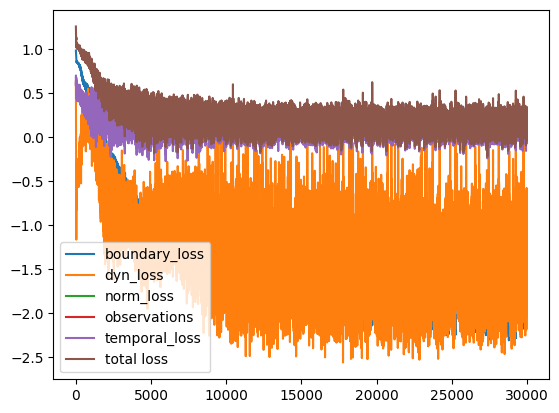

In [20]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_weights[loss_name] * loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

Plot the PDE solution learned by the PINN

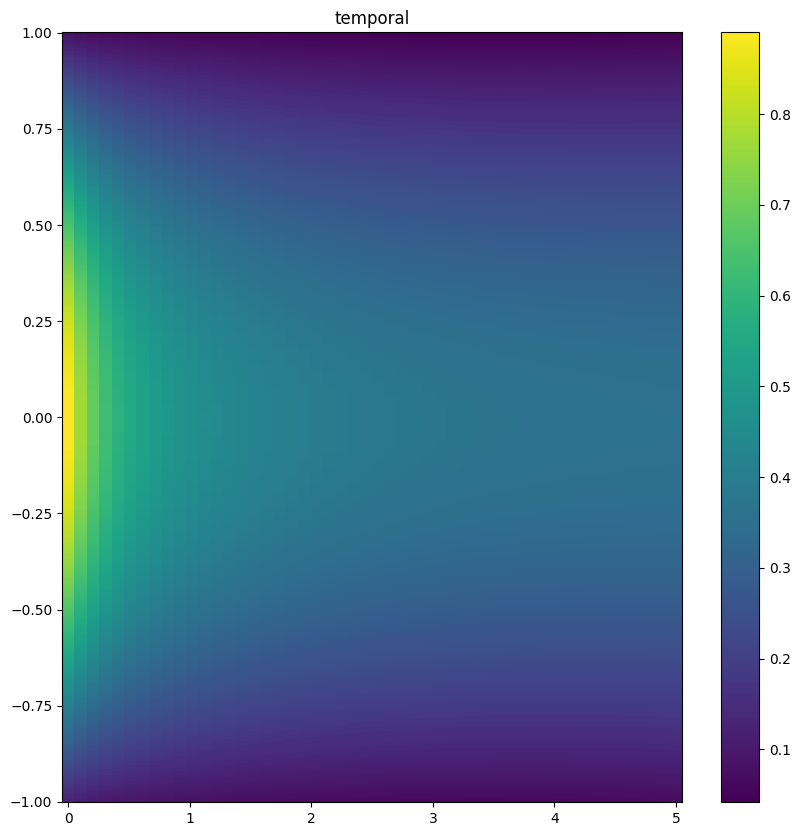

In [21]:
u_est = partial(u, u_params=params["nn_params"])

# same subkey
jinns.data.plot1d_image(u_est, xdata=val_xdata, times=val_times, Tmax=Tmax, cmap="viridis", colorbar=True, figsize=(10,10), title="temporal")

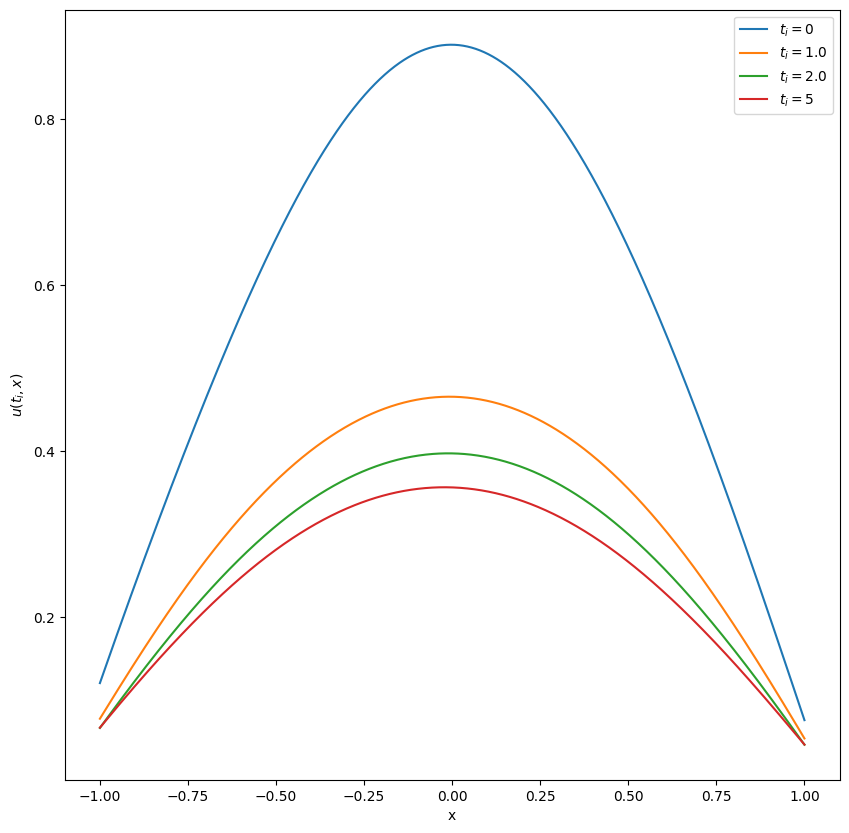

In [22]:
time_slices = [0, 0.2, 0.4, 1]
jinns.data.plot1d_slice(u_est, xdata=val_xdata, time_slices=time_slices, Tmax=Tmax)

## Compare with the analytical solution
See Fig III.1 p 73 of the book _Modèles de réaction-diffusion pour l'écologie spatiale_ by Lionel Roques. Our estimation seems good. Note that we have a slightly different Gaussian initial condition as the book does not explicit their choice for `u0`.